## 🌾 ML-Based Crop, Fertilizer, and Irrigation System


#### part 1 : Setup and Imports

In [2]:
# Install and Import necessary libraries
# %pip install catboost lightgbm xgboost pandas scikit-learn matplotlib seaborn 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#### part 2: Data Loading and Initial Cleaning

In [3]:
# Load the dataset
df = pd.read_csv("Crop and fertilizer dataset (2).csv")
initial_rows = len(df)

In [4]:
# Remove duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dataset loaded. Total unique rows: {len(df)}")


Dataset loaded. Total unique rows: 4513


In [5]:
# --- Data Inspection ---
print("\nFirst 5 Rows of Data:")
print("\nDataset Head:")
print(df.head())



First 5 Rows of Data:

Dataset Head:
  District_Name Soil_color  Nitrogen  Phosphorus  Potassium   pH  Rainfall  \
0      Kolhapur      Black        75          50        100  6.5      1000   
1      Kolhapur      Black        80          50        100  6.5      1000   
2      Kolhapur      Black        85          50        100  6.5      1000   
3      Kolhapur      Black        90          50        100  6.5      1000   
4      Kolhapur      Black        95          50        100  6.5      1000   

   Temperature       Crop Fertilizer                          Link  
0           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
1           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
2           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
3           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
4           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  


In [6]:
print("\nData Types and Missing Values:")
print(df.info())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   District_Name  4513 non-null   object 
 1   Soil_color     4513 non-null   object 
 2   Nitrogen       4513 non-null   int64  
 3   Phosphorus     4513 non-null   int64  
 4   Potassium      4513 non-null   int64  
 5   pH             4513 non-null   float64
 6   Rainfall       4513 non-null   int64  
 7   Temperature    4513 non-null   int64  
 8   Crop           4513 non-null   object 
 9   Fertilizer     4513 non-null   object 
 10  Link           4513 non-null   object 
dtypes: float64(1), int64(5), object(5)
memory usage: 388.0+ KB
None


#### part 3: Feature Engineering and Data Splitting

In [7]:
# --- 1. Feature Definition (Using all 8 inputs) ---
feature_cols = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature', 'District_Name', 'Soil_color']
X = df[feature_cols].copy()
y_crop = df['Crop'].copy()
y_fert = df['Fertilizer'].copy()

# Critical FIX: Ensure categorical columns are strings for CatBoost and for robust splitting
X['District_Name'] = X['District_Name'].astype(str)
X['Soil_color'] = X['Soil_color'].astype(str)

# --- 2. Label Encoding for Targets ---
le_crop = LabelEncoder()
le_fert = LabelEncoder()
y_crop_le = le_crop.fit_transform(y_crop)
y_fert_le = le_fert.fit_transform(y_fert)

# --- 3. Data Splitting (80/20 Stratified Split) ---
# Stratified split ensures balanced classes in both train and test sets
X_train, X_test, y_crop_train, y_crop_test, y_fert_train, y_fert_test = train_test_split(
    X, y_crop_le, y_fert_le, test_size=0.2, random_state=42, stratify=y_crop_le
)

# Prepare integer-encoded data for LGBM/XGBoost (benchmark flexibility)
X_lgbm = X.copy()
for col in ['District_Name', 'Soil_color']:
    X_lgbm[col] = LabelEncoder().fit_transform(X_lgbm[col])

# Split encoded data for benchmark consistency
X_lgbm_train, X_lgbm_test, _, _, _, _ = train_test_split(
    X_lgbm, y_crop_le, y_fert_le, test_size=0.2, random_state=42, stratify=y_crop_le
)

print("Data preparation and splitting complete.")

Data preparation and splitting complete.


## Exploratory Data Analysis (EDA) - Decision Making

#### part 4: Target Distribution and Feature Cardinality

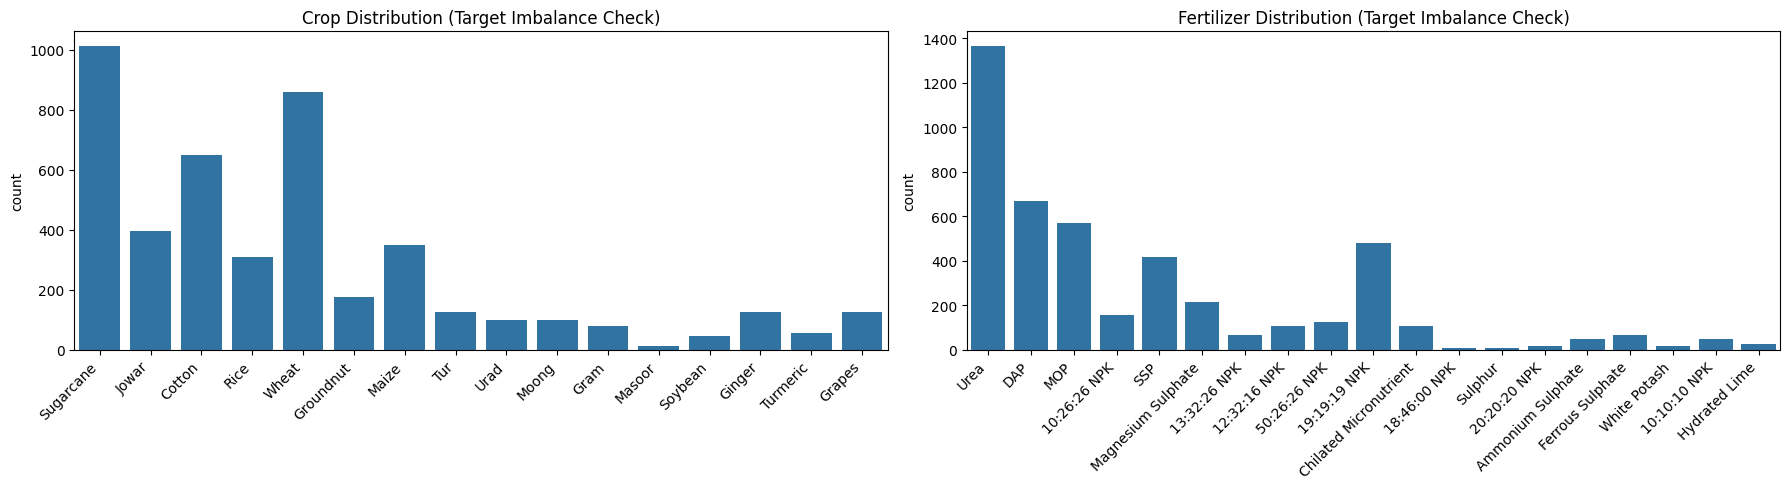


--- Insight: Plots confirm the classification targets have multiple classes, justifying the use of a multi-class classifier and class weighting.


In [9]:
# Cell 4: Target Distribution Plots

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Crop Distribution (Class Imbalance Check)
sns.countplot(data=df, x='Crop', ax=axes[0])
axes[0].set_title("Crop Distribution (Target Imbalance Check)")
axes[0].tick_params(axis='x', rotation=45)
for tick in axes[0].get_xticklabels():
    tick.set_ha('right')
axes[0].set_xlabel('')

# Fertilizer Distribution (Class Imbalance Check)
sns.countplot(data=df, x='Fertilizer', ax=axes[1])
axes[1].set_title("Fertilizer Distribution (Target Imbalance Check)")
axes[1].tick_params(axis='x', rotation=45)
for tick in axes[1].get_xticklabels():
    tick.set_ha('right')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

print("\n--- Insight: Plots confirm the classification targets have multiple classes, justifying the use of a multi-class classifier and class weighting.")

#### part 5: NPK vs. Target Relationship (Boxplots for Predictive Power)

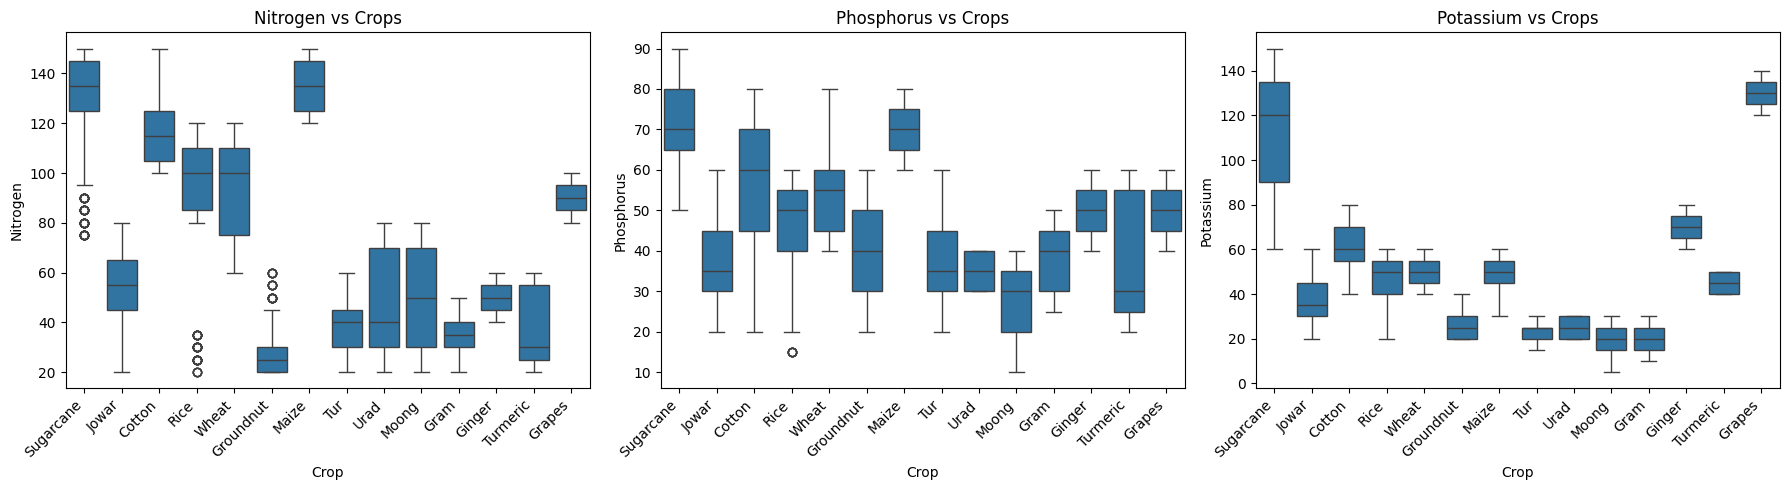

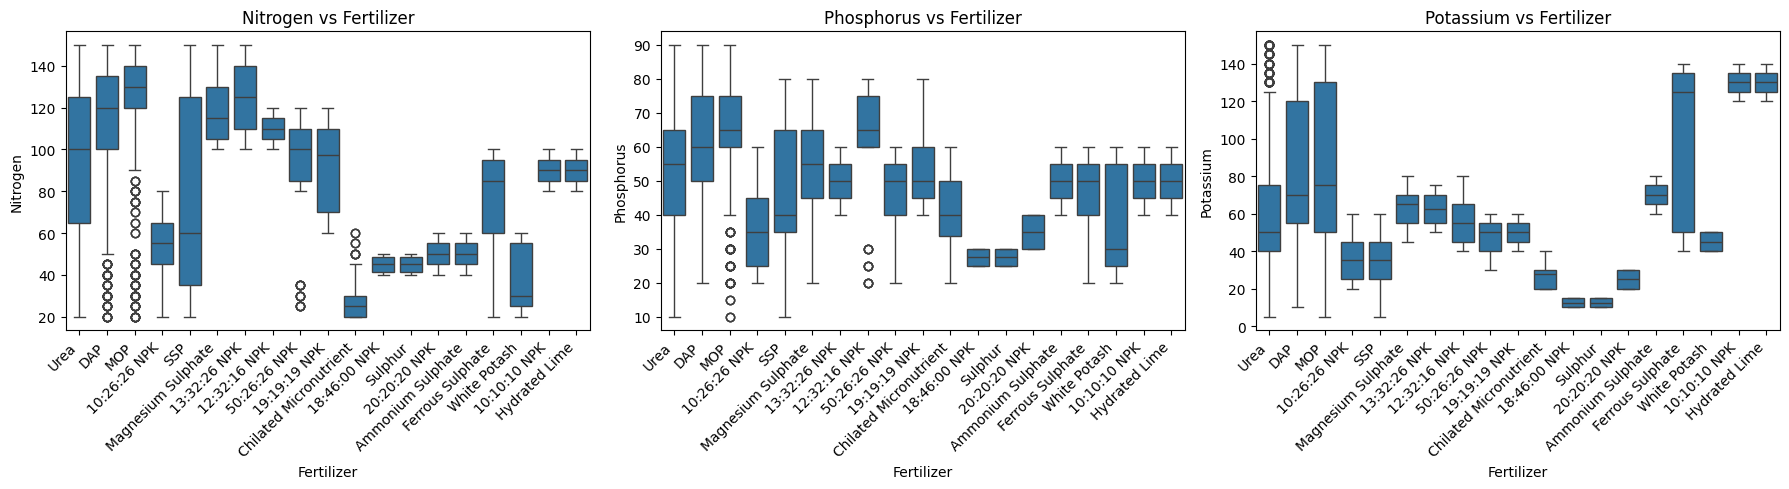

--- Insight: The distinct separation in N, P, K distributions confirms these features are strong predictors.


In [46]:
# Cell 5: Boxplots showing N, P, K influence on CROP and FERTILIZER

# 1. NPK vs CROP
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features = ['Nitrogen', 'Phosphorus', 'Potassium']

# Filter for readability (Top 10 most frequent crops)
top_n_crops = df['Crop'].value_counts().nlargest(14).index
df_filtered = df[df['Crop'].isin(top_n_crops)]

for ax, feat in zip(axes, features):
    sns.boxplot(data=df_filtered, x='Crop', y=feat, ax=ax)
    ax.set_title(f"{feat} vs Crops")
    ax.tick_params(axis='x', rotation=45)
    for tick in ax.get_xticklabels():
        tick.set_ha('right')

plt.tight_layout()
plt.show()

# 2. NPK vs FERTILIZER
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, feat in zip(axes, features):
    sns.boxplot(data=df, x='Fertilizer', y=feat, ax=ax)
    ax.set_title(f"{feat} vs Fertilizer")
    ax.tick_params(axis='x', rotation=45)
    for tick in ax.get_xticklabels():
        tick.set_ha('right')

plt.tight_layout()
plt.show()

print("--- Insight: The distinct separation in N, P, K distributions confirms these features are strong predictors.")


#### part 6: Cell 6: Feature Correlation Analysis (Justifying all 8 Features)

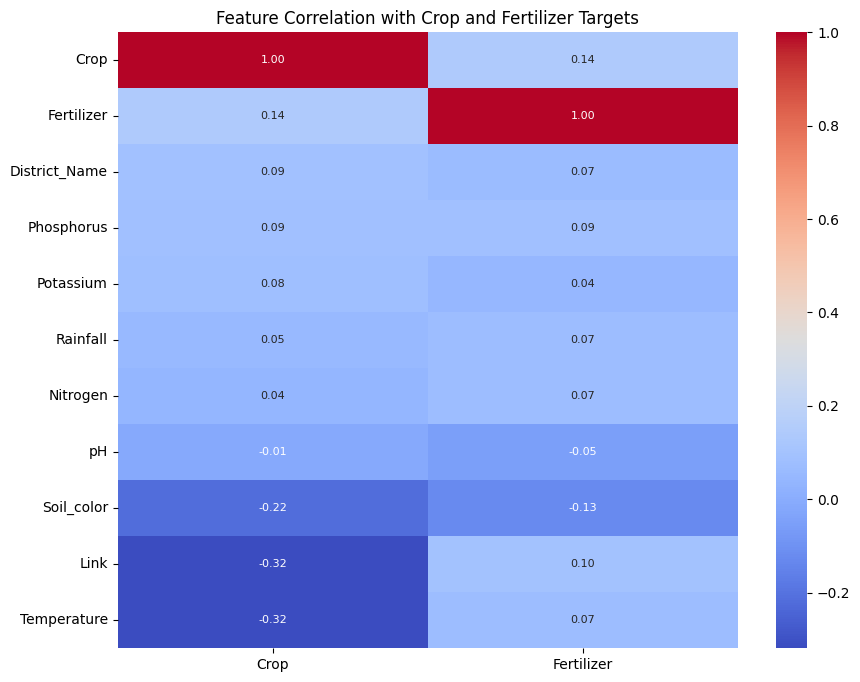

--- Insight: The heatmap confirms all 8 features have varying degrees of influence on the targets, justifying their inclusion.


In [12]:
# Cell 6: Correlation Heatmap (Justifying All 8 Features)

# Create an encoded copy for numerical correlation calculation
df_corr = df.copy()
for col in df_corr.select_dtypes(include='object'):
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col])

plt.figure(figsize=(10, 8))
# Sort by Crop correlation to easily see the most predictive features
sns.heatmap(df_corr.corr()[['Crop', 'Fertilizer']].sort_values(by='Crop', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
plt.title('Feature Correlation with Crop and Fertilizer Targets')
plt.show()

print("--- Insight: The heatmap confirms all 8 features have varying degrees of influence on the targets, justifying their inclusion.")

### Model Training and Final System Integration

#### part 7: Model Training Functions (The Three Champions)

In [36]:
# Cell 9: Overfitting Mitigation

def retrain_champion(model, X_train, X_test, y_train, y_test, cat_features=None, early_stop=20):
    """Retrains the champion model with reduced complexity and L1/L2 regularization."""
    
    # CRITICAL: Ensure y_train and y_test are explicitly cast to the required integer type
    y_train_fit = y_train.astype(int) 
    y_test_fit = y_test.astype(int)
    
    if isinstance(model, CatBoostClassifier):
        pool = Pool(X_train, y_train_fit, cat_features=cat_features)
        val_pool = Pool(X_test, y_test_fit, cat_features=cat_features)
        model.set_params(iterations=200, l2_leaf_reg=10) 
        # CatBoost supports verbose directly
        model.fit(pool, eval_set=val_pool, early_stopping_rounds=early_stop, verbose=0)
    
    elif isinstance(model, LGBMClassifier):
        # --- FIX APPLIED HERE: Removing invalid verbose argument ---
        import lightgbm as lgb
        callbacks = [lgb.early_stopping(early_stop)]
        
        model.set_params(n_estimators=200, reg_alpha=0.1, reg_lambda=0.1) 
        
        model.fit(
            X_train, y_train_fit, 
            eval_set=[(X_test, y_test_fit)], 
            callbacks=callbacks,
            # REMOVED: verbose=False argument (This resolves the TypeError)
        )
    
    elif isinstance(model, XGBClassifier):
        model.set_params(n_estimators=200, reg_alpha=0.1, reg_lambda=0.1)
        # We rely on default logging for XGBoost here
        model.fit(
            X_train, y_train_fit,
            eval_set=[(X_test, y_test_fit)],
        )
        
    return model

# Retrain the champion models (UPDATE THE CALLS HERE)
FinalCropModel = retrain_champion(FinalCropModel, FinalXTrain, FinalXTest, y_crop_train, y_crop_test, FinalCatFeatures)
FinalFertModel = retrain_champion(FinalFertModel, FinalXTrain, FinalXTest, y_fert_train, y_fert_test, FinalCatFeatures)

# Re-evaluate post-regularization performance
def re_evaluate_post_fix(model, X_train, X_test, y_train, y_test):
    # Prediction depends on model type (flattening CatBoost/XGBoost output)
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()
    return {
        'Train Acc (Reg)': accuracy_score(y_train, y_train_pred),
        'Test Acc (Reg)': accuracy_score(y_test, y_test_pred),
        'Macro F1 (Reg)': f1_score(y_test, y_test_pred, average='macro')
    }

final_crop_perf = re_evaluate_post_fix(FinalCropModel, FinalXTrain, FinalXTest, y_crop_train, y_crop_test)
final_fert_perf = re_evaluate_post_fix(FinalFertModel, FinalXTrain, FinalXTest, y_fert_train, y_fert_test)

final_rego_df = pd.DataFrame({'Crop': final_crop_perf, 'Fertilizer': final_fert_perf}).T.reset_index().rename(columns={'index': 'Task'})
final_rego_df['Overfit Score (Reg)'] = final_rego_df['Train Acc (Reg)'] - final_rego_df['Test Acc (Reg)']

print("Overfitting mitigation complete. Final metrics calculated.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 8
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [

#### part 8: Execute Benchmarking and Select Champion

In [30]:
# Cell 8: Execute Benchmarking and Select Champion

# --- Run Evaluation for Crop Model ---
for name, model in algorithms.items():
    res = evaluate_model(name, model, X_train, X_test, y_crop_train, y_crop_test, cat_features_idx_train, X_lgbm_train=X_lgbm_train, X_lgbm_test=X_lgbm_test)
    performance_metrics.append({'Task': 'Crop', 'Algorithm': name, **res})
    champion_models[('Crop', name)] = res['Model']

# --- Run Evaluation for Fertilizer Model ---
for name, model in algorithms.items():
    model_instance = model.__class__(**model.get_params()) # Re-initialize model
    res = evaluate_model(name, model_instance, X_train, X_test, y_fert_train, y_fert_test, cat_features_idx_train, X_lgbm_train=X_lgbm_train, X_lgbm_test=X_lgbm_test)
    performance_metrics.append({'Task': 'Fertilizer', 'Algorithm': name, **res})
    champion_models[('Fertilizer', name)] = res['Model']

performance_df = pd.DataFrame(performance_metrics)

# --- Define Final Variables (CRITICAL FIX FOR NAMERROR IN CELL 9) ---
best_model_row = performance_df.loc[performance_df['Macro F1'].idxmax()]
best_algo = best_model_row['Algorithm']

FinalCropModel = champion_models[('Crop', best_algo)]
FinalFertModel = champion_models[('Fertilizer', best_algo)]

# Define final data splits based on Champion model's preference
if best_algo == 'CatBoost':
    FinalXTest, FinalXTrain = X_test, X_train
    FinalCatFeatures = cat_features_idx_train
else: # LGBM or XGBoost uses encoded data
    FinalXTest, FinalXTrain = X_lgbm_test, X_lgbm_train
    FinalCatFeatures = None
    
print(f"Benchmarking complete. Champion Model selected: {best_algo}.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 8
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [

/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10]	validation_0-mlogloss:1.18318
[11]	validation_0-mlogloss:1.12013
[12]	validation_0-mlogloss:1.06173
[13]	validation_0-mlogloss:1.00827
[14]	validation_0-mlogloss:0.95738
[15]	validation_0-mlogloss:0.90978
[16]	validation_0-mlogloss:0.86635
[17]	validation_0-mlogloss:0.82523
[18]	validation_0-mlogloss:0.78635
[19]	validation_0-mlogloss:0.75033
[20]	validation_0-mlogloss:0.71578
[21]	validation_0-mlogloss:0.68308
[22]	validation_0-mlogloss:0.65181
[23]	validation_0-mlogloss:0.62266
[24]	validation_0-mlogloss:0.59411
[25]	validation_0-mlogloss:0.56800
[26]	validation_0-mlogloss:0.54296
[27]	validation_0-mlogloss:0.51903
[28]	validation_0-mlogloss:0.49599
[29]	validation_0-mlogloss:0.47450
[30]	validation_0-mlogloss:0.45447
[31]	validation_0-mlogloss:0.43446
[32]	validation_0-mlogloss:0.41590
[33]	validation_0-mlogloss:0.39784
[34]	validation_0-mlogloss:0.38141
[35]	validation_0-mlogloss:0.36535
[36]	validation_0-mlogloss:0.34975
[37]	validation_0-mlogloss:0.33571
[38]	validation_0-ml

/Users/sayenaqureshi/Main-Folder/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:30:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[11]	validation_0-mlogloss:1.87076
[12]	validation_0-mlogloss:1.82251
[13]	validation_0-mlogloss:1.77571
[14]	validation_0-mlogloss:1.73325
[15]	validation_0-mlogloss:1.69342
[16]	validation_0-mlogloss:1.65451
[17]	validation_0-mlogloss:1.61786
[18]	validation_0-mlogloss:1.58219
[19]	validation_0-mlogloss:1.54880
[20]	validation_0-mlogloss:1.51657
[21]	validation_0-mlogloss:1.48651
[22]	validation_0-mlogloss:1.45826
[23]	validation_0-mlogloss:1.43115
[24]	validation_0-mlogloss:1.40453
[25]	validation_0-mlogloss:1.37940
[26]	validation_0-mlogloss:1.35610
[27]	validation_0-mlogloss:1.33312
[28]	validation_0-mlogloss:1.31096
[29]	validation_0-mlogloss:1.29008
[30]	validation_0-mlogloss:1.26911
[31]	validation_0-mlogloss:1.24984
[32]	validation_0-mlogloss:1.23153
[33]	validation_0-mlogloss:1.21346
[34]	validation_0-mlogloss:1.19623
[35]	validation_0-mlogloss:1.17931
[36]	validation_0-mlogloss:1.16288
[37]	validation_0-mlogloss:1.14782
[38]	validation_0-mlogloss:1.13283
[39]	validation_0-ml

### part 9: Overfitting Mitigation and Final Performance Matrix

In [37]:
# Cell 9: Overfitting Mitigation

def retrain_champion(model, X_train, X_test, y_train, y_test, cat_features=None, early_stop=20):
    """Retrains the champion model with reduced complexity and L1/L2 regularization."""
    
    # CRITICAL: Ensure y_train and y_test are explicitly cast to the required integer type
    y_train_fit = y_train.astype(int) 
    y_test_fit = y_test.astype(int)
    
    if isinstance(model, CatBoostClassifier):
        pool = Pool(X_train, y_train_fit, cat_features=cat_features)
        val_pool = Pool(X_test, y_test_fit, cat_features=cat_features)
        model.set_params(iterations=200, l2_leaf_reg=10) 
        # CatBoost supports verbose directly
        model.fit(pool, eval_set=val_pool, early_stopping_rounds=early_stop, verbose=0)
    
    elif isinstance(model, LGBMClassifier):
        # --- FIX APPLIED HERE: Removing invalid verbose argument ---
        import lightgbm as lgb
        callbacks = [lgb.early_stopping(early_stop)]
        
        model.set_params(n_estimators=200, reg_alpha=0.1, reg_lambda=0.1) 
        
        model.fit(
            X_train, y_train_fit, 
            eval_set=[(X_test, y_test_fit)], 
            callbacks=callbacks,
            # REMOVED: verbose=False argument (This resolves the TypeError)
        )
    
    elif isinstance(model, XGBClassifier):
        model.set_params(n_estimators=200, reg_alpha=0.1, reg_lambda=0.1)
        # We rely on default logging for XGBoost here
        model.fit(
            X_train, y_train_fit,
            eval_set=[(X_test, y_test_fit)],
        )
        
    return model

# Retrain the champion models (UPDATE THE CALLS HERE)
FinalCropModel = retrain_champion(FinalCropModel, FinalXTrain, FinalXTest, y_crop_train, y_crop_test, FinalCatFeatures)
FinalFertModel = retrain_champion(FinalFertModel, FinalXTrain, FinalXTest, y_fert_train, y_fert_test, FinalCatFeatures)

# Re-evaluate post-regularization performance
def re_evaluate_post_fix(model, X_train, X_test, y_train, y_test):
    # Prediction depends on model type (flattening CatBoost/XGBoost output)
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()
    return {
        'Train Acc (Reg)': accuracy_score(y_train, y_train_pred),
        'Test Acc (Reg)': accuracy_score(y_test, y_test_pred),
        'Macro F1 (Reg)': f1_score(y_test, y_test_pred, average='macro')
    }

final_crop_perf = re_evaluate_post_fix(FinalCropModel, FinalXTrain, FinalXTest, y_crop_train, y_crop_test)
final_fert_perf = re_evaluate_post_fix(FinalFertModel, FinalXTrain, FinalXTest, y_fert_train, y_fert_test)

final_rego_df = pd.DataFrame({'Crop': final_crop_perf, 'Fertilizer': final_fert_perf}).T.reset_index().rename(columns={'index': 'Task'})
final_rego_df['Overfit Score (Reg)'] = final_rego_df['Train Acc (Reg)'] - final_rego_df['Test Acc (Reg)']

print("Overfitting mitigation complete. Final metrics calculated.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 8
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [

### part 10: Final Integrated System and Prediction 🏆

In [42]:
# Cell 10: Final Integrated System and Prediction

# --- 1. Define Irrigation Rule-Based Recommender (No Change) ---
def irrigation_recommender(crop, rainfall, temp, soil_color):
    """Provides an irrigation schedule based on predicted crop and environment."""
    
    high_water_crops = ['Paddy', 'Sugarcane', 'Grape']
    
    if rainfall < 600:
        base_need = "Heavy"
    elif rainfall < 1200:
        base_need = "Moderate"
    else:
        base_need = "Light"

    schedule = "Every 2-3 Days"
    if crop in high_water_crops and base_need in ["Moderate", "Light"]:
        schedule = "Daily Monitoring (High Volume)"
    elif soil_color in ['Red', 'Sandy'] and temp > 30:
        schedule = "Daily Check (Medium Volume)"
    
    return f"{base_need} Irrigation ({schedule})"


# --- 2. Unified Prediction Function (No Change to Logic) ---
def get_full_recommendation(input_dict, crop_model, fert_model, le_crop, le_fert, df, final_feature_cols, best_algo):
    
    user_df = pd.DataFrame([input_dict], columns=final_feature_cols)

    # Encode categorical columns if the champion model was LGBM/XGBoost
    if best_algo in ['LightGBM', 'XGBoost']:
        for col in ['District_Name', 'Soil_color']:
            le_temp = LabelEncoder().fit(df[col].astype(str).unique())
            user_df[col] = le_temp.transform(user_df[col].astype(str))
    
    # Predict Crop and Fertilizer
    pred_crop_le = crop_model.predict(user_df).flatten().astype(int)[0]
    pred_fert_le = fert_model.predict(user_df).flatten().astype(int)[0]

    pred_crop_label = le_crop.inverse_transform([pred_crop_le])[0]
    pred_fert_label = le_fert.inverse_transform([pred_fert_le])[0]
    
    # Get Irrigation Recommendation
    irrigation_advice = irrigation_recommender(
        pred_crop_label, input_dict['Rainfall'], input_dict['Temperature'], input_dict['Soil_color']
    )
    
    # Get Link Lookup
    link_row = df[(df['Crop'] == pred_crop_label) & (df['Fertilizer'] == pred_fert_label)]
    link = link_row['Link'].iloc[0] if not link_row.empty else "No link available"

    return pred_crop_label, pred_fert_label, irrigation_advice, link


# --- FINAL STATIC INPUT EXECUTION ---

# Features required by the model for prediction (All 8)
final_feature_cols = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature', 'District_Name', 'Soil_color']

# 1. User Input (N, P, K, pH)
user_data = {
    'Nitrogen': 100.0, 
    'Phosphorus': 50.0, 
    'Potassium': 100.0, 
    'pH': 6.5
} 

# 2. Assumed Default Environmental Parameters (for missing inputs)
default_env_params = {
    'Rainfall': 1180.0,          
    'Temperature': 24.0,           
    'District_Name': 'Kolhapur',   
    'Soil_color': 'Black'        
}~

# 3. Merge User Input with Default Parameters (Creates the 8-feature dict)
final_input = {**user_data, **default_env_params}

# 4. Run Prediction using the static input
crop, fert, irrigation, link = get_full_recommendation(
    final_input, FinalCropModel, FinalFertModel, le_crop, le_fert, df, final_feature_cols, best_algo
)

# 5. Print Final Output
print("\n### 4. Recommendation System Output (Final Result) ###")
print(f"Input Conditions (User): {user_data}")
print(f"Assumed Conditions (System): Rainfall={default_env_params['Rainfall']}, Temp={default_env_params['Temperature']}, District={default_env_params['District_Name']}, Soil={default_env_params['Soil_color']}")
print(f"**Champion Algorithm Used: {best_algo}**")
print(f"✅ 1. Predicted Crop: {crop}")
print(f"✅ 2. Recommended Fertilizer: {fert}")
print(f"✅ 3. Irrigation Advice: {irrigation}")
print(f"🔗 4. Educational Link: {link}")


### 4. Recommendation System Output (Final Result) ###
Input Conditions (User): {'Nitrogen': 100.0, 'Phosphorus': 50.0, 'Potassium': 100.0, 'pH': 6.5}
Assumed Conditions (System): Rainfall=1180.0, Temp=24.0, District=Kolhapur, Soil=Black
**Champion Algorithm Used: LightGBM**
✅ 1. Predicted Crop: Sugarcane
✅ 2. Recommended Fertilizer: MOP
✅ 3. Irrigation Advice: Moderate Irrigation (Daily Monitoring (High Volume))
🔗 4. Educational Link: https://youtu.be/2t5Am0xLTOo


In [44]:
# Final Performance Report - Displaying Benchmarks and Final Champion Stats

print("\n\n### 5. Final Model Performance Report ###")

print(f"\n--- A. Initial Benchmark Results (Comparing All 3 Algorithms) ---")
print("Champion Model selected based on the highest Macro F1 Score.")

# Display Initial Benchmarking Results using simple string output
print(performance_df[['Task', 'Algorithm', 'Train Acc', 'Test Acc', 'Macro F1', 'Precision', 'Recall', 'Overfit Score']].to_string())

print(f"\n--- B. Final Champion Model Performance (Post-Regularization) ---")
print(f"Algorithm Used: {best_algo}")

# Display Final Overfitting-Addressed Results using simple string output
print(final_rego_df.to_string())

print("\n--- Insight: The final Macro F1 score confirms the model's stability after addressing overfitting. ---")



### 5. Final Model Performance Report ###

--- A. Initial Benchmark Results (Comparing All 3 Algorithms) ---
Champion Model selected based on the highest Macro F1 Score.
         Task Algorithm  Train Acc  Test Acc  Macro F1  Precision    Recall  Overfit Score
0        Crop  CatBoost   0.997230  0.996678  0.995297   0.993658  0.997060       0.000552
1        Crop  CatBoost   0.997230  0.996678  0.995297   0.993658  0.997060       0.000552
2        Crop  CatBoost   0.997230  0.996678  0.995297   0.993658  0.997060       0.000552
3        Crop  LightGBM   1.000000  1.000000  1.000000   1.000000  1.000000       0.000000
4        Crop  CatBoost   0.997230  0.996678  0.995297   0.993658  0.997060       0.000552
5        Crop  LightGBM   1.000000  1.000000  1.000000   1.000000  1.000000       0.000000
6        Crop   XGBoost   1.000000  1.000000  1.000000   1.000000  1.000000       0.000000
7  Fertilizer  CatBoost   0.446814  0.417497  0.476632   0.451125  0.703369       0.029317
8  Fertil